In [128]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, trapezoid as trapz
from iminuit import Minuit
import pandas as pd
from tqdm import tqdm

# Project 1

In [142]:
XMIN, XMAX = 0, 10
NBINS = 200

In [143]:
def params(data_type):
    '''data_type in order [V, tau, dm]'''
    if data_type == 'sig':
        return 0.1, 1.5, 20.0
    if data_type == 'bgd':
        return 0.0, 8, 0.0

# Create PDF Class 
## To generate psudo random values for this funtion:

$P(t; \tau, \delta m_s, V ) \propto (1 + V sin(\delta mt)) × e^{−t/\tau}$

Since it is proportional I will need to add a constant in front when fitting to normalise the function.


#### Maximum value of the function:

$\frac{\delta}{\delta t}(1 + V sin(\delta mt)) × e^{−t/\tau} 
= \frac{1}{\tau} e^{-t/\tau} (\delta m t V cos(\delta m t) - V sin(\delta mt)-1)$

at $t=0$, the function simply becomes,

$\frac{1}{\tau} (\delta m \tau V - 1) = \delta m V - 1/\tau$

In [152]:
class MyPDF:
    '''class to generate random numbers distributed as the given function using the box method
     Args:      * lolimit, hilimit = lower and upper bounds of the data to be generated
                * V, tau, dm = parameters of the function (optional)
    
     Variables: * ts = list of random numbers distributed as the given function
                * norm = normalisation constant from evaluate method using initally passed parameters V, tau and dm 
                * maxval = max value of the function (differentiated function of func set = 0)
                * bin_centres = list of bin centres of the histogram of the generated data

     Methods:   * evaluate() returns value at point x unnormalised
                * integrate() returns the normalisation constant from evaluate function
                * generate_data() generates a list of random numbers distributed as the given function using box method
                * NLL() returns the NLL value of the given normalised evaluate function
                * calc_bin_centres() calculates the bin centres of the histogram of the generated data'''
    
    def __init__( self, lolimit, hilimit, V=0.1, tau=1.5, dm=20.0):
        self.lolimit = lolimit
        self.hilimit = hilimit
        self.V, self.tau, self.dm = V, tau, dm
        self.ts = []
        self.bin_centres = []
        self.norm = self.integrate(self.V, self.tau, self.dm)
        self.maxval = (dm * V - 1/tau)/self.norm # differentited function of func set = 0

    def evaluate(self, t, V, tau, dm):
        return (1 + V*np.sin(dm*t)) * np.exp(-t/tau)
    
    def integrate(self, V, tau, dm):
        # x = np.linspace(self.lolimit, self.hilimit, 10000)
        # y = self.evaluate(x, V, tau, dm)
        # return trapz(y=y, x=x, dx=0.05) # integrate using trapezoidal rule 
        return quad(self.evaluate, self.lolimit, self.hilimit, args=(V, tau, dm), limit=100)[0] # integrate using quad method
    
    def calc_bin_centres(self):
        n_obs, bin_edges = np.histogram(self.ts, NBINS, density=True) # normalised histogram
        self.bin_centres = np.full(len(n_obs), 0) # initialise bin centres array with zeros 

        ## calculate bin centres ##
        for i in range(len(n_obs)):
            self.bin_centres[i] = (bin_edges[i] + bin_edges[i+1])/2
    
    def generate_data( self, nopoints=10000 ): # number of points to generate, optional
        while (len(self.ts) < nopoints):
            ## start with uniform random number in [ XMIN , YMIN ] ##
            t = np.random.uniform( self.lolimit, self.hilimit ) # generate t value
            y1 = self.evaluate(t, self.V, self.tau, self.dm) / self.norm # calculate y value
            y2 = np.random.uniform() * self.maxval # generate random number between 0 and maxval
            if (y2 < y1):
                self.ts.append(t) # accept t value if less than maxval
        self.calc_bin_centres()

    def NLL( self, V, tau, dm ): 
        ## calculate NLL ##
        y = self.evaluate(self.bin_centres, V, tau, dm) / self.integrate(V, tau, dm)
        # n_obs = self.bin_centres
        # y[y <= 0.] = 1e-5  # to prevent dividing by 0
        # n_obs[n_obs <= 0.] = 1e-5
        
        return - np.sum(np.log(y))
        # return 2*np.sum(y - n_obs + n_obs * np.log(n_obs/y))

In [153]:
pdf = MyPDF(XMIN, XMAX)
pdf.generate_data(10000)

## run Minuit ##
startvals = {'V': 0.1, 'tau': 1.5, 'dm': 20.0} 
m = Minuit(pdf.NLL, **startvals)
m.errordef = 0.5
m.limits['V'], m.limits['tau'], m.limits['dm'] =[0, 1], [0, 10], [0, 100] # limits on parameters V, tau and dm
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 359                        │              Nfcn = 170              │
│ EDM = 0.000464 (Goal: 0.0001)    │            time = 1.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V    │   1.000   │   0.007   │            │            │    0    │    1    │       │
│ 1 │ tau  │   10.0    │    0.9    │            │            │    0    │   10    │       │
│ 2 │ dm   │  25.385   │   0.013   │            │            │    0    │   100   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬───────────────────────────────┐
│     │         V       tau        dm │
├─────┼───────────────────────────────┤
│   V │  3.32e-16  0.02e-15 44.42e-15 │
│ tau │  0.02e-15  6.96e-13   1.2e-12 │
│  dm │ 44.42e-15   1.2e-12  0.000179 │
└─────┴───────────────────────────────┘

# Part 1

- Generate data by calling the generate_method in the Gaussian class
- Plot a histogram to check everything is working as expected
- fit using minuit

## Visulaising the data

In [71]:
gauss = MyPDF( XMIN, XMAX )
gauss.generate_data(100000)

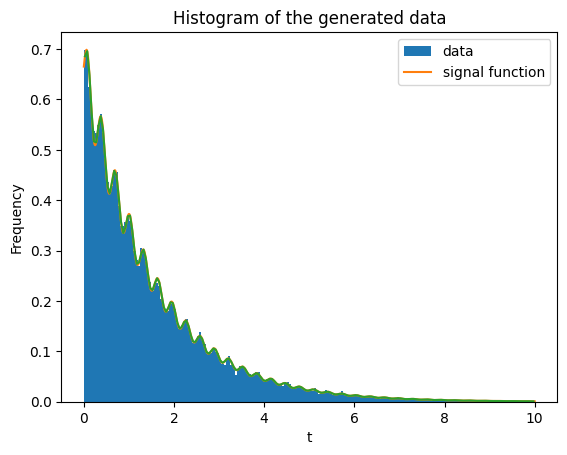

In [145]:
plt.hist(gauss.ts, bins=NBINS, density=True, label='data')
x = np.linspace(XMIN, XMAX, 1000)
plt.plot(x, gauss.evaluate(x, *params('sig')) / gauss.norm, label='signal function')
plt.title('Histogram of the generated data')
plt.xlabel('t')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Maximum liklihood fit

In [123]:
def toy_MC(nots=10000, nosims=100, V=0.1, tau=1.5, dm=20.0):
    mydict = {'V': [], 'Verr':[], 'tau': [], 'tauerr':[], 'dm': [], 'dmerr':[]} # dictionary to store results
    for _ in tqdm(range(nosims)):
        ## create pdf object and generate data ##
        pdf = MyPDF(XMIN, XMAX)
        pdf.generate_data(nots)

        ## run Minuit ##
        startvals = {'V': V, 'tau': tau, 'dm': dm} 
        m = Minuit(pdf.NLL, **startvals)
        m.errordef = 0.5
        m.limits['V'], m.limits['tau'], m.limits['dm'] =[0, 1], [0, 10], [0, 100] # limits on parameters V, tau and dm
        m.migrad()
        ## save values and errors ##
        mydict['V'].append(m.values['V']), mydict['Verr'].append(m.errors['V'])
        mydict['tau'].append(m.values['tau']), mydict['tauerr'].append(m.errors['tau'])
        mydict['dm'].append(m.values['dm']), mydict['dmerr'].append(m.errors['dm'])

    ## convert to dataframe ##
    df = pd.DataFrame(mydict)
    return df

In [124]:
df1 = toy_MC(nosims=20)

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:01<00:28,  1.49s/it]C:\Users\hanna\AppData\Local\Temp\ipykernel_34660\2938199318.py:33: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(self.evaluate, self.lolimit, self.hilimit, args=(V, tau, dm))[0] # integrate using quad method
 15%|█▌        | 3/20 [00:06<00:39,  2.33s/it]C:\Users\hanna\AppData\Local\Temp\ipykernel_34660\2938199318.py:33: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(self.evaluate, self.lolimi

## Fitting with the NLL
For some values of the parameters the integral to normalise the function does in converge quickly. I get this warning:

    IntegrationWarning: The maximum number of subdivisions (50) has been achieved

and,
 
    The integral is probably divergent, or slowly convergent.

So I have deicided to use a different method for integrating, the trapezium rule

## Showing the results from the MC simulation

In [125]:
mean_params = df1.mean(axis=0)
std_params = df1.std(axis=0)

In [126]:
print('V: ', round(mean_params['V'], 3), ' +/- ', round(std_params['V'], 4))
print('tau: ', round(mean_params['tau'], 2), ' +/- ', round(std_params['tau'], 4))
print('d_m: ',round( mean_params['dm'], 3), ' +/- ', round(std_params['dm'], 4))

V:  0.104  +/-  0.3066
tau:  10.0  +/-  0.0
d_m:  20.706  +/-  19.745


## plotting a histogram of the fitted results

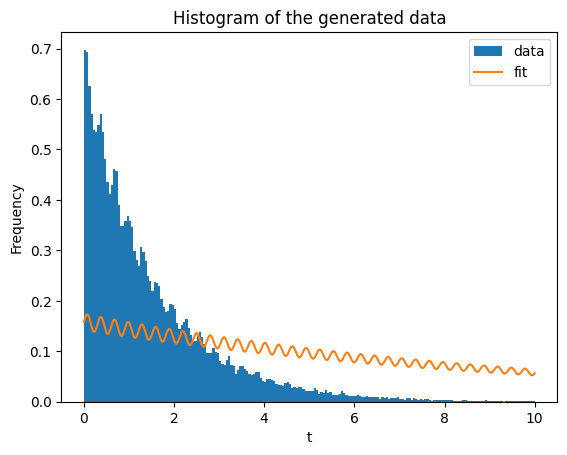

In [127]:
plt.hist(gauss.ts, bins=NBINS, density=True, label='data')
x = np.linspace(XMIN, XMAX, 1000)
norm = gauss.integrate(mean_params['V'], mean_params['tau'], mean_params['dm'])
plt.plot(x, gauss.evaluate(x, mean_params['V'], mean_params['tau'], mean_params['dm']) / norm, label='fit')
plt.title('Histogram of the generated data')
plt.xlabel('t')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Part 2

## The signal with background class

In [46]:
class SignalWithBackground:
    '''class to combine signal and background distributions based on the background fraction
       by randomly selecting from the two distributions.

    Args:       * nodatapoints = number of data points to be generated = len(ts_sig) + len(ts_bgd)
                * bgd_frac = background fraction

    Variables:  * nodata = set to the argument nodatapoints
                * ts = list of selected background and signal data points
                * ts_sig = list of signal data points
                * ts_bgd = list of background data points
                * sig_params = parameters of the signal function
                * bgd_params = parameters of the background function
                * signal = object of MyPDF class set with signal parameters
                * background = object of MyPDF class set with background parameters

    Methods:    * generate_mixed_data() generates a list of random numbers distributed as the given 
                  fraction of signal and background
                '''
    
    def __init__(self, nodatapoints, bgd_frac):
        self.nodata, self.bgd_frac = nodatapoints, bgd_frac
        self.ts = []
        self.ts_sig, self.ts_bgd = [], []
        self.sig_params = params('sig')
        self.bgd_params = params('bgd')
        self.signal = MyPDF(XMIN, XMAX, *self.sig_params)
        self.background = MyPDF(XMIN, XMAX, *self.bgd_params)
        self.signal.generate_data(nodatapoints)
        self.background.generate_data(nodatapoints)


    ## Create distribution given the background fraction ##
    def generate_mixed_data(self):
        sigcount, bgdcount = 0, 0
        while len(self.ts) < self.nodata:
            ## generate random number to determine which (sig, bgd) to take from ##
            q = np.random.uniform()
            if (q < (1 - self.bgd_frac)):
                ## take from Signal ##
                filtered_t = self.signal.ts[sigcount]
                self.ts_sig.append(filtered_t)
                sigcount += 1
            else:
                ## Take from Background ##
                filtered_t = self.background.ts[bgdcount]
                self.ts_bgd.append(filtered_t)
                bgdcount += 1
            self.ts.append(filtered_t)


## Varying the Background fraction

In [47]:
def part_2_toy(nodatapoints=10000):
    ## V, tau, dm are stored in this order in the dictionary ##
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    plt.suptitle('Histogram of the generated data and fits', fontsize=23)
    fracs = {0:[], 0.1:[], 0.2:[], 0.3:[], 0.4:[]}
    axs_dim, count = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1)], 0
    for frac in fracs:
        ## setting up the data ##
        mixed_sim = SignalWithBackground(nodatapoints=nodatapoints, bgd_frac=frac)
        mixed_sim.generate_mixed_data()
        pdf = MyPDF(XMIN, XMAX, *params('sig'))
        pdf.ts = mixed_sim.ts

        ## fitting the data with minuit ##
        startvals = {'V': params('sig')[0], 'tau': params('sig')[1], 'dm': params('sig')[2]} 
        m = Minuit(pdf.NLL, **startvals)
        m.errordef = 0.5
        m.migrad()

        ## record values and errors to the dictionary ##
        fracs[frac].append(m.values['V']), fracs[frac].append(m.errors['V'])
        fracs[frac].append(m.values['tau']), fracs[frac].append(m.errors['tau'])
        fracs[frac].append(m.values['dm']), fracs[frac].append(m.errors['dm'])
                
        ## plotting the histogram and fit to check everthing is ok ##
        ax = axs[axs_dim[count]]
        ax.hist(mixed_sim.ts, bins=NBINS, density=True)
        x = np.linspace(XMIN, XMAX, 10000)
        ax.plot(x, pdf.evaluate(x, *m.values)/pdf.integrate(*m.values))
        ax.set_title('Background Fraction = ' + str(frac))
        ax.text(0.05, 0.95, 'V = ' + str(round(m.values['V'], 3)) + ' +/- ' + str(round(m.errors['V'], 3)), 
                transform=ax.transAxes, fontsize=14, verticalalignment='top')
        ax.text(0.05, 0.90, 'tau = ' + str(round(m.values['tau'], 2)) + ' +/- ' + str(round(m.errors['tau'], 3)), 
                transform=ax.transAxes, fontsize=14, verticalalignment='top')
        ax.text(0.05, 0.85, 'dm = ' + str(round(m.values['dm'], 3)) + ' +/- ' + str(round(m.errors['dm'], 2)), 
                transform=ax.transAxes, fontsize=14, verticalalignment='top')
        ax.set_xlabel('t'), ax.set_ylabel('Frequency')
        ax.set_xlim(XMIN, XMAX)
        count += 1
        print(f'F = {frac} fit done\n')
        
    ## removing the last subplot ##
    fig.delaxes(axs[1, 2])
    ## converting the dictionary to a dataframe ##
    df = pd.DataFrame(fracs).T
    return df

F = 0 fit done


C:\Users\hanna\AppData\Local\Temp\ipykernel_34660\1781010434.py:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(self.evaluate, self.lolimit, self.hilimit, args=(V, tau, dm))[0]


F = 0.1 fit done


C:\Users\hanna\AppData\Local\Temp\ipykernel_34660\1781010434.py:28: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(self.evaluate, self.lolimit, self.hilimit, args=(V, tau, dm))[0]
C:\Users\hanna\AppData\Local\Temp\ipykernel_34660\1781010434.py:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(self.evaluate, self.lolimit, self.hilimit, args=(V, tau, dm))[0]


F = 0.2 fit done


C:\Users\hanna\AppData\Local\Temp\ipykernel_34660\1781010434.py:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(self.evaluate, self.lolimit, self.hilimit, args=(V, tau, dm))[0]


F = 0.3 fit done


C:\Users\hanna\AppData\Local\Temp\ipykernel_34660\1781010434.py:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(self.evaluate, self.lolimit, self.hilimit, args=(V, tau, dm))[0]


F = 0.4 fit done


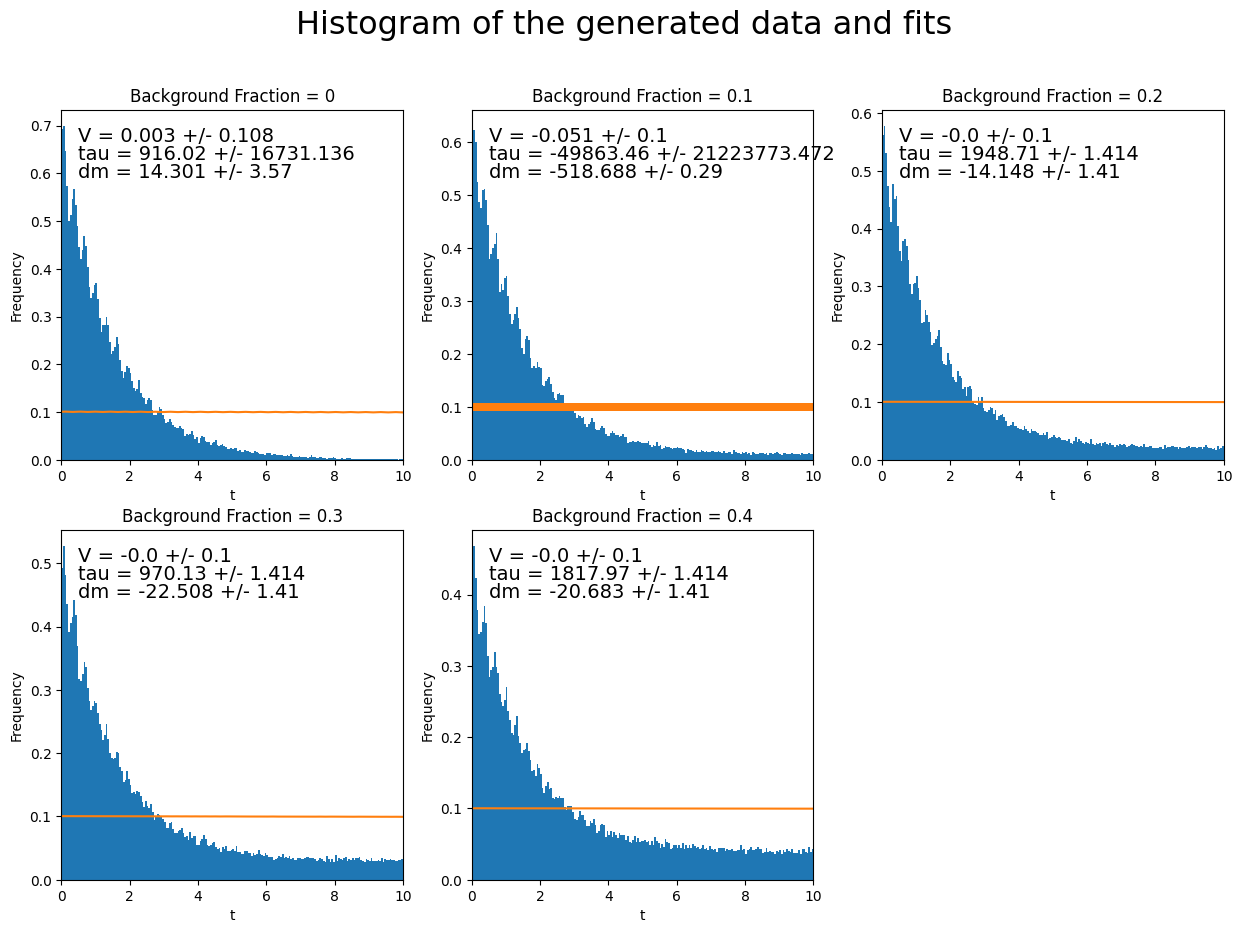

In [48]:
df2 = part_2_toy(nodatapoints=100000)
df2.columns = ['V', 'Verr', 'tau', 'tauerr', 'dm', 'dmerr']

#### Table of parameters and their errors for each Background fraction

In [23]:
df2

,V,Verr,tau,tauerr,dm,dmerr
0.0,-0.004872,15.960176,198.485904,22.037413,-0.001305,4.351718
0.1,0.000345,0.025229,1999.069955,15317.322681,0.224590,1529.537967
0.2,-0.030744,0.001530,-384153.719464,78446.758480,382.423263,0.000296
0.3,0.001810,0.118632,1386.750380,42335.345582,-0.538295,9.205335
0.4,-0.000319,0.000000,9423.022659,0.000000,-12.872821,0.000000


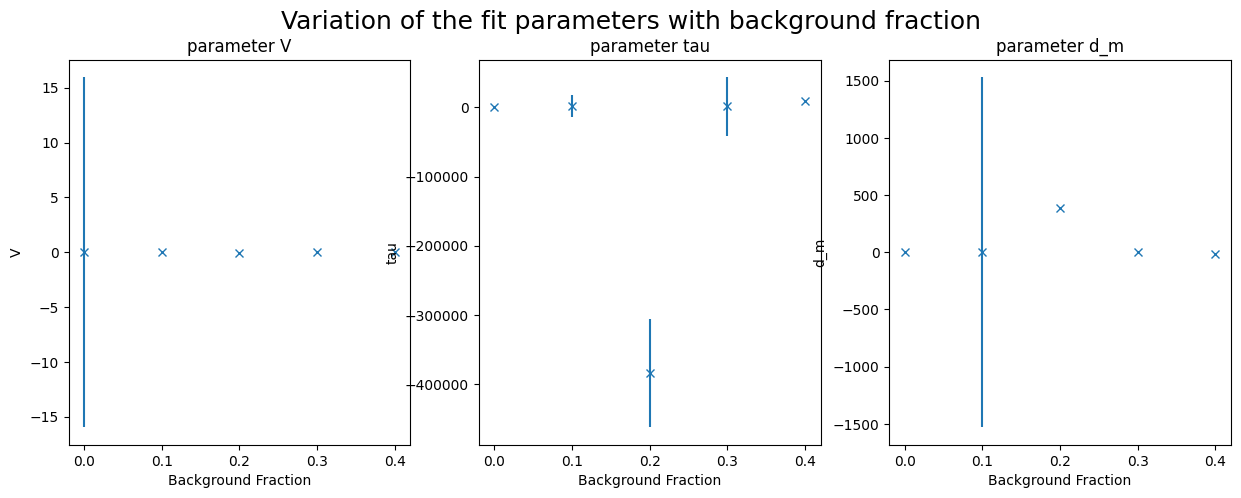

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].errorbar(df2.index, df2['V'], yerr=df2['Verr'], fmt='x')
axs[0].set_xlabel('Background Fraction')
axs[0].set_ylabel('V')
axs[0].set_title('parameter V')
axs[1].errorbar(df2.index, df2['tau'], yerr=df2['tauerr'], fmt='x')
axs[1].set_xlabel('Background Fraction')
axs[1].set_ylabel('tau')
axs[1].set_title('parameter tau')
axs[2].errorbar(df2.index, df2['dm'], yerr=df2['dmerr'], fmt='x')
axs[2].set_xlabel('Background Fraction')
axs[2].set_ylabel('d_m')
axs[2].set_title('parameter d_m')
plt.suptitle('Variation of the fit parameters with background fraction', fontsize=18)
plt.show()

## Biasies

In [25]:
shifts = {'V':[], 'tau':[], 'dm':[]}

print('shift in parameters due to added background\n')
for i in df2.index:
    shifts['V'].append(mean_params['V'] - df2.loc[i, 'V'])
    shifts['tau'].append(mean_params['tau'] - df2.loc[i, 'tau'])
    shifts['dm'].append(mean_params['dm'] - df2.loc[i, 'dm'])

    print(f'BGD Fraction = {i}')
    print('V = ', round(shifts['V'][-1], 4), ', | tau = ', round(shifts['tau'][-1], 4), ', | d_m = ', round(shifts['dm'][-1], 4), '\n')

shift in parameters due to added background

BGD Fraction = 0.0
V =  0.008 , | tau =  101.0508 , | d_m =  30.6473 

BGD Fraction = 0.1
V =  0.0028 , | tau =  -1699.5332 , | d_m =  30.4214 

BGD Fraction = 0.2
V =  0.0339 , | tau =  384453.2562 , | d_m =  -351.7772 

BGD Fraction = 0.3
V =  0.0013 , | tau =  -1087.2136 , | d_m =  31.1843 

BGD Fraction = 0.4
V =  0.0034 , | tau =  -9123.4859 , | d_m =  43.5188 

